# Chapter 19 大规模训练和部署 TensorFlow 模型

一旦你有了一个可以做出惊人预测的漂亮模型，你会用它做什么？好吧，你需要把它投入生产！这可能就像在一批数据上运行模型一样简单，并且可能编写每晚运行该模型的脚本。但是，它通常涉及更多。基础设施的各个部分可能需要在实时数据上使用此模型，在这种情况下，您可能希望将模型包装在 Web 服务中：这样，基础设施的任何部分都可以使用简单的 REST API 随时查询模型（或其他一些协议），正如我们在第 2 章中讨论的那样。但是随着时间的推移，您将需要定期根据新数据重新训练您的模型并将更新版本推送到生产环境。您必须处理模型版本控制，从一个模型优雅地过渡到下一个模型，在出现问题时可能回滚到前一个模型，并且可能并行运行多个不同的模型以执行 **A/B 实验（A/B 实验包括针对不同的用户子集测试产品的两个不同版本，以检查哪个版本效果最好并获得其他见解）**。如果您的产品成功，您的服务可能会开始获得大量 **每秒查询（Query Per Second，QPS）**，并且必须扩展以支持负载。正如您将在本章中看到的那样，扩展服务的一个很好的解决方案是在您自己的硬件基础设施上或通过 Google Vertex AI 等云服务使用 TF Serving。它将负责高效地为您的模型提供服务，处理优雅的模型转换，等等。如果您使用云平台，您还将获得许多额外的功能，例如强大的监控工具。

此外，如果你有大量的训练数据和计算密集型模型，那么训练时间可能会非常长。如果您的产品需要快速适应变化，那么长时间的训练可能会成为阻碍（例如，想想一个新闻推荐系统来宣传上周的新闻）。也许更重要的是，长时间的训练会阻止你尝试新的想法。在机器学习（和许多其他领域一样）中，很难事先知道哪些想法会奏效，因此您应该尽快尝试尽可能多的想法。加速训练的一种方法是使用硬件加速器，例如 GPU 或 TPU。为了走得更快，您可以在多台机器上训练一个模型，每台机器都配备了多个硬件加速器。正如您将看到的，TensorFlow 简单而强大的分布策略 API 使这一切变得简单。

在本章中，我们将了解如何部署模型，首先使用 TF Serving，然后使用 Vertex AI。我们还将快速了解如何将模型部署到移动应用程序、嵌入式设备和 Web 应用程序。然后我们将讨论如何使用 GPU 加速计算，以及如何使用分布策略 API 跨多个设备和服务器训练模型。最后，我们将探讨如何使用 Vertex AI 大规模训练模型和微调超参数。有很多话题要讨论，让我们开始吧！

## Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
import sys
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U google-cloud-aiplatform

In [4]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

## 1. 部署一个 TensorFlow 模型（Serving a TensorFlow Model）

一旦你训练了一个 TensorFlow 模型，你就可以很容易地在任何 Python 代码中使用它：如果它是一个 Keras 模型，只需调用它的 predict() 方法！但是随着您的基础设施的增长，有时最好将您的模型包装在一个小型服务中，该服务的唯一作用是进行预测并让基础设施的其余部分查询它（例如，通过 REST 或 gRPC API）。这将您的模型与基础架构的其余部分分离，从而可以轻松切换模型版本或根据需要扩展服务（独立于基础架构的其余部分），执行 A/B 实验，并确保您的所有软件组件依赖相同的模型版本。它还简化了测试和开发等。您可以使用任何您想要的技术（例如，使用 Flask 库）来创建自己的微服务，但是既然可以使用 **TF Serving**，为什么还要重新发明轮子呢？

### 1.1 使用 TensorFlow Serving（Using TensorFlow Serving）

TF Serving 是一个非常高效、经过实战检验的模型服务器，用 C++ 编写。它可以维持高负载，为模型的多个版本提供服务，并观察模型存储库以自动部署最新版本，等等（见下图）。

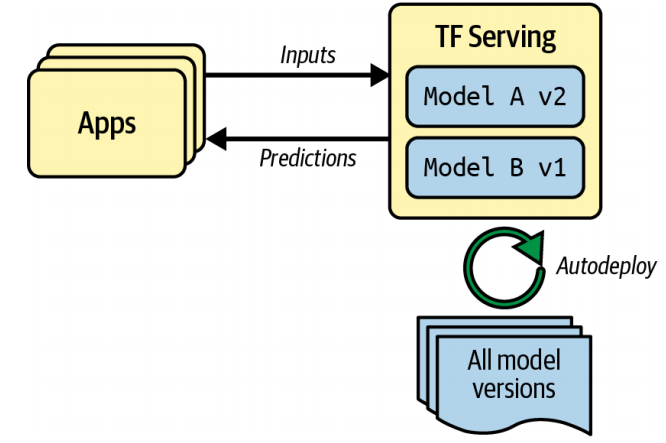

所以，假设您已经使用 Keras 训练了一个 MNIST 模型，并且您希望将其部署到 TF Serving 中。您要做的第一件事是将此模型导出到第 10 章中介绍的 **SavedModel 格式** 。

#### 1.1.1 导出保存模型（Exporting SavedModels）

您已经知道如何保存模型：只需调用 **model.save()** 。现在要对模型进行版本控制，您只需为每个模型版本创建一个子目录。简单的！

In [5]:
from pathlib import Path
import tensorflow as tf

# extra code – load and split the MNIST dataset
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# extra code – build & train an MNIST model (also handles image preprocessing)
tf.random.set_seed(42)
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28], dtype=tf.uint8),
    tf.keras.layers.Rescaling(scale=1 / 255),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2),
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

model_name = "my_mnist_model"
model_version = "0001"
model_path = Path(model_name) / model_version
model.save(model_path, save_format="tf")

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.6834 - accuracy: 0.8262 - val_loss: 0.3691 - val_accuracy: 0.9008
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3526 - accuracy: 0.9021 - val_loss: 0.3014 - val_accuracy: 0.9176
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3033 - accuracy: 0.9143 - val_loss: 0.2670 - val_accuracy: 0.9286
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2730 - accuracy: 0.9229 - val_loss: 0.2444 - val_accuracy: 0.9340
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2498 - accuracy: 0.9299 - val_loss: 0.2251 - val_accuracy: 0.9370
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2308 - accuracy: 0.9358 - val_loss: 0.2109 - val_accuracy: 0.9426
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2149 - accuracy: 0.9401 - val_loss: 0.1962 - val_accuracy:

将所有预处理层包含在您导出的最终模型中通常是个好主意，这样它就可以在部署到生产环境后以自然形式摄取数据。这避免了在使用模型的应用程序中单独处理预处理。将预处理步骤捆绑在模型中还可以简化以后的更新，并限制模型与其所需的预处理步骤不匹配的风险。

**注意**：由于 SavedModel 保存了计算图，因此它只能用于完全基于 TensorFlow 操作的模型，不包括包装任意 Python 代码的 **tf.py_function()** 操作。

TensorFlow 带有一个小型的 **saved_model_cli** 命令行界面来检查 SavedModels。让我们用它来检查我们导出的模型：

In [6]:
sorted([str(path) for path in model_path.parent.glob("**/*")])  # extra code

['my_mnist_model\\0001',
 'my_mnist_model\\0001\\assets',
 'my_mnist_model\\0001\\keras_metadata.pb',
 'my_mnist_model\\0001\\saved_model.pb',
 'my_mnist_model\\0001\\variables',
 'my_mnist_model\\0001\\variables\\variables.data-00000-of-00001',
 'my_mnist_model\\0001\\variables\\variables.index']

In [7]:
!saved_model_cli show --dir my_mnist_model/0001

The given SavedModel contains the following tag-sets:
'serve'


这个输出是什么意思？嗯，一个 SavedModel 包含一个或多个 **元图（metagraphs）**。元图是一个计算图加上一些函数签名定义，包括它们的输入和输出名称、类型和形状。每个元图由一组标签标识。例如，您可能想要一个包含完整计算图的元图，包括训练操作：您通常会将其标记为 **"train"**。您可能还有另一个元图，其中包含仅包含预测操作的修剪计算图，包括一些特定于 GPU 的操作：这个可能被标记为 **"serve"**、**"gpu"**。您可能还想拥有其他元图。这可以使用 TensorFlow 的低级 **SavedModel API** 来完成。但是，当您使用其 **save()** 方法保存 Keras 模型时，它会保存一个标记为 **"serve"** 的元图。让我们检查一下这个 **"serve"** 标签集：

In [8]:
!saved_model_cli show --dir my_mnist_model/0001 --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


此元图包含两个签名定义：一个名为 `"__saved_model_init_op"` 的初始化函数，您无需担心，以及一个名为 `"serving_default"` 的默认服务函数。保存 Keras 模型时，默认服务函数是模型的 **call()** 方法，如您所知，它会进行预测。让我们了解有关此服务函数的更多详细信息：

In [9]:
!saved_model_cli show --dir my_mnist_model/0001 --tag_set serve \
                      --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['flatten_input'] tensor_info:
      dtype: DT_UINT8
      shape: (-1, 28, 28)
      name: serving_default_flatten_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


请注意，函数的输入名为 `"flatten_input"`，输出名为 `"dense_1"`。这些对应于 Keras 模型的输入和输出层名称。您还可以查看输入和输出数据的类型和形状。看起来不错！

现在您有了 SavedModel，下一步是安装 TF Serving。

#### 1.1.2 安装和启动 TensorFlow Serving（Installing and starting TensorFlow Serving）

安装 TF Serving 的方法有很多种：使用系统的包管理器、使用 Docker 映像、从源中安装等等。由于 Colab 在 Ubuntu 上运行，我们可以像这样使用 Ubuntu 的 apt 包管理器：

In [10]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    url = "https://storage.googleapis.com/tensorflow-serving-apt"
    src = "stable tensorflow-model-server tensorflow-model-server-universal"
    !echo 'deb {url} {src}' > /etc/apt/sources.list.d/tensorflow-serving.list
    !curl '{url}/tensorflow-serving.release.pub.gpg' | apt-key add -
    !apt update -q && apt-get install -y tensorflow-model-server
    %pip install -q -U tensorflow-serving-api

此代码首先将 TensorFlow 的包存储库添加到 Ubuntu 的包源列表中。然后它下载 TensorFlow 的公共 GPG 密钥并将其添加到包管理器的密钥列表中，以便它可以验证 TensorFlow 的包签名。接下来，它使用 apt 安装 tensorflow-model-server 包。最后，它安装了我们需要与服务器通信的 tensorflow-serving-api 库。

现在我们要启动服务器。该命令将需要基本模型目录的绝对路径（即 `my_mnist_model` 的路径，而不是 0001），因此让我们将其保存到 `MODEL_DIR` 环境变量中：

In [23]:
import os

os.environ["MODEL_DIR"] = str(model_path.parent.absolute())

model_path.parent.absolute()

WindowsPath("C:/Users/tu'tu/Desktop/一些课外内容/机器学习/神经网络与深度学习（Edition 3）/my_mnist_model")

然后我们可以启动服务器：

In [19]:
%%bash --bg
tensorflow_model_server \
    --port=8500 \
    --rest_api_port=8501 \
    --model_name=my_mnist_model \
    --model_base_path="${MODEL_DIR}" >my_server.log 2>&1

在 Jupyter 或 Colab 中，`%%bash --bg` 魔术命令将单元作为 `bash` 脚本执行，在后台运行。`>my_server.log 2>&1` 部分将标准输出和标准错误重定向到 `my_server.log` 文件。就是这样！TF Serving 现在在后台运行，其日志保存到 `my_server.log`。它加载了我们的 MNIST 模型（version 1），现在正在等待端口 8500 和 8501 上的 gRPC 和 REST 请求。

现在服务器已经启动并运行，让我们查询它，首先使用 REST API，然后使用 gRPC API。

#### 1.1.3 在 Docker Container 中运行 TF Serving（Running TF Serving in a Docker Container）

如果您在自己的机器上运行 notebook 并且安装了 Docker，则可以在终端中运行 `docker pull tensorflow/serving` 以下载 TF Serving 映像。TensorFlow 团队强烈推荐这种安装方法，因为它简单，不会弄乱你的系统，而且性能高。要在 Docker Container 内启动服务器，您可以在终端中运行以下命令：`docker run -it --rm -v "/path/to/my_mnist_model:/models/my_mnist_model" \
 -p 8500:8500 -p 8501:8501 -e MODEL_NAME=my_mnist_model tensorflow/serving`

下面是所有这些命令行选项的含义：

- `-it`：使 Container 具有交互性（因此您可以按 Ctrl-C 来停止它）并显示服务器的输出。
- `--rm`：停止时删除 Container ：不需要用中断的 Container 弄乱你的机器。但是，它不会删除映像。
- `-v`：`"/path/to/my_mnist_model:/models/my_mnist_model"` 使主机的 `my_mnist_model` 目录可供路径 `/models/mnist_model` 中的 Container 使用。您必须将 `/path/to/my_mnist_model` 替换为此目录的绝对路径。在 Windows 上，请记住在主机路径中使用 `\` 而不是 `/`，但不要在容器路径中使用（因为容器在 Linux 上运行）。
- `-p 8500:8500`：使 Docker 引擎将主机的 TCP 端口 8500 转发到容器的 TCP 端口 8500。默认情况下，TF Serving 使用此端口为 gRPC API 提供服务。
- `-p 8501:8501`：将主机的 TCP 端口 8501 转发到容器的 TCP 端口 8501。Docker 镜像配置为默认使用此端口来为 REST API 提供服务。
- `-e MODEL_NAME=my_mnist_model`：设置容器的 `MODEL_NAME` 环境变量，以便 TF Serving 知道要服务哪个模型。默认情况下，它会在 /models 目录中查找模型，并自动提供找到的最新版本。
- `tensorflow/serving`：这是要运行的映像的名称。

#### 1.1.4 通过 REST API 查询 TF Serving（Querying TF Serving through the REST API）

让我们从创建查询开始。它必须包含您要调用的函数签名的名称，当然还有输入数据。由于请求必须使用 JSON 格式，我们必须将输入图像从 NumPy 数组转换为 Python 列表：

In [13]:
import json

X_new = X_test[:3]  # pretend we have 3 new digit images to classify

request_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_new.tolist(),
})

请注意，JSON 格式是 100% 基于文本的。请求字符串如下所示：

In [15]:
request_json[:100] + "..." + request_json[-10:]

'{"signature_name": "serving_default", "instances": [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..., 0, 0]]]}'

现在让我们通过 HTTP POST 请求将此请求发送到 TF Serving。这可以使用 `requests` 库来完成（它不是 Python 标准库的一部分，但它预装在 Colab 上）：

In [ ]:
import requests

server_url = "http://localhost:8501/v1/models/my_mnist_model:predict"
response = requests.post(server_url, data=request_json)
response.raise_for_status()  # raise an exception in case of error
response = response.json()

如果一切顺利，响应应该是一个包含单个 `"prediction"` 键的字典。相应的值是预测列表。这个列表是一个 Python 列表，所以让我们把它转换成一个 NumPy 数组，并将它包含的浮点数四舍五入到小数点后第二位：

In [ ]:
import numpy as np

y_proba = np.array(response["predictions"])
y_proba.round(2)

欢呼，我们有预测！该模型对第一张图像是 7 的置信度接近 100%，对第二张图像是 2 的置信度接近 99%，对第三张图像是 1 的置信度接近 97%。这是正确的。

REST API 很好用，也很简单，当输入和输出数据不是太大时，它工作得很好。此外，几乎任何客户端应用程序都可以在没有附加依赖项的情况下进行 REST 查询，而其他协议并不总是那么容易获得。但是，它基于 JSON，这是基于文本的并且相当冗长。例如，我们必须将 NumPy 数组转换为 Python 列表，并且每个浮点数最终都表示为一个字符串。这是非常低效的，无论是在序列化/反序列化时间方面（我们必须将所有浮点数转换为字符串并返回），还是在有效负载大小方面：许多浮点数最终使用超过 15 个字符表示，转换为超过 120 位 对于 32 位浮点数！这将在传输大型 NumPy 数组时导致高延迟和带宽使用。因此，让我们看看如何改用 gRPC。

当传输大量数据或延迟很重要时，如果客户端支持，最好使用 gRPC API，因为它使用紧凑的二进制格式和基于 HTTP/2 框架的高效通信协议。

#### 1.1.5 通过 gRPC API 查询 TF Serving（Querying TF Serving through the gRPC API）

gRPC API 需要一个序列化的 `PredictRequest` 协议缓冲区作为输入，它输出一个序列化的 `PredictResponse` 协议缓冲区。这些 protobufs 是我们之前安装的 `tensorflow-serving-api` 库的一部分。首先，让我们创建请求：

In [ ]:
from tensorflow_serving.apis.predict_pb2 import PredictRequest

request = PredictRequest()
request.model_spec.name = model_name
request.model_spec.signature_name = "serving_default"
input_name = model.input_names[0]  # == "flatten_input"
request.inputs[input_name].CopyFrom(tf.make_tensor_proto(X_new))

此代码创建一个 `PredictRequest` 协议缓冲区并填写所需字段，包括模型名称（之前定义）、我们要调用的函数的签名名称，最后是输入数据，以 `Tensor` 协议缓冲区的形式。`tf.make_tensor_proto()` 函数基于给定的张量或 NumPy 数组创建一个 `Tensor` 协议缓冲区，在本例中为 `X_new`。

接下来，我们将请求发送到服务器并获得它的响应。为此，我们需要 Colab 中预装的 grpcio 库：

In [ ]:
import grpc
from tensorflow_serving.apis import prediction_service_pb2_grpc

channel = grpc.insecure_channel('localhost:8500')
predict_service = prediction_service_pb2_grpc.PredictionServiceStub(channel)
response = predict_service.Predict(request, timeout=10.0)

代码非常简单：导入后，我们在 TCP 端口 8500 上创建一个到本地主机的 gRPC 通信通道，然后我们通过该通道创建一个 gRPC 服务并使用它发送请求，超时为 10 秒。请注意，调用是同步的：它将阻塞直到收到响应或超时期限到期。在此示例中，通道是不安全的（无加密，无身份验证），但 gRPC 和 TF 服务也支持基于 SSL/TLS 的安全通道。

接下来，让我们将 `PredictResponse` 协议缓冲区转换为张量：

In [ ]:
output_name = model.output_names[0]
outputs_proto = response.outputs[output_name]
y_proba = tf.make_ndarray(outputs_proto)

In [ ]:
y_proba.round(2)

In [ ]:
# extra code – shows how to avoid using tf.make_ndarray()
output_name = model.output_names[0]
outputs_proto = response.outputs[output_name]
shape = [dim.size for dim in outputs_proto.tensor_shape.dim]
y_proba = np.array(outputs_proto.float_val).reshape(shape)
y_proba.round(2)

如果您运行此代码并打印 `y_proba.round(2)`，您将获得与之前完全相同的估计类别概率。这就是它的全部内容：只需几行代码，您现在就可以使用 REST 或 gRPC 远程访问您的 TensorFlow 模型。

#### 1.1.6 部署一个新的模型版本（Deploying a new model version）

现在让我们创建一个新的模型版本并导出一个 `SavedModel`，这次是到 `my_mnist_model/0002` 目录：

In [27]:
import numpy as np

# extra code – build and train a new MNIST model version
np.random.seed(42)
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28], dtype=tf.uint8),
    tf.keras.layers.Rescaling(scale=1 / 255),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7163 - accuracy: 0.8057 - val_loss: 0.3398 - val_accuracy: 0.9056
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3210 - accuracy: 0.9086 - val_loss: 0.2639 - val_accuracy: 0.9260
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2679 - accuracy: 0.9220 - val_loss: 0.2254 - val_accuracy: 0.9350
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2349 - accuracy: 0.9317 - val_loss: 0.2043 - val_accuracy: 0.9418
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2110 - accuracy: 0.9390 - val_loss: 0.1840 - val_accuracy: 0.9468
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1923 - accuracy: 0.9447 - val_loss: 0.1725 - val_accuracy: 0.9514
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1772 - accuracy: 0.9491 - val_loss: 0.1618 - val_accuracy: